In [1]:
import os
import torch
import dgl
import numpy as np
import csv
from gnn_heto_model import HeteroGCN
from gnn_heto_link_pred_model import HeteroLinkGCN
from gnn_heto_with_attention_model import HeteroGCNWithAllAttention
from gnn_model import GCN
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import argparse
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import logging
from weak_ML2 import SimpleCNN, evaluate_cnn, train_cnn
from weakDense import SimpleDense, evaluate_dense, train_dense
import pickle


In [2]:
graph_folder = os.path.join('saved_graphs','google_commands','clique','filter')
model_folder = 'models'
matrix_folder = os.path.join('saved_matrix','google_commands', 'filter')


In [46]:
glists, _ = dgl.load_graphs(os.path.join(graph_folder, 'fixed', 'glove',f"hetero_graph_-3000_1_-3000_3000.dgl"))
hetero_graph = glists[0]

with open(f'phon_idx_google_commands.pkl', 'rb') as f:
        phon_idx = pickle.load(f)
   

In [47]:
# Load the heterogeneous GCN model
features_dic = {
    'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
    'word': hetero_graph.nodes['word'].data['feat']
}

In [48]:
in_feats = {'acoustic': features_dic['acoustic'].shape[1], 'word': features_dic['word'].shape[1]}
hidden_size = hetero_graph.nodes['word'].data['feat'].shape[1]
linear_hidden_size = 64
nb_phon = hetero_graph.nodes['word'].data['feat'].shape[1]
#out_feats = len(labels.unique())

In [49]:
model_hetero_regressor = HeteroLinkGCN(in_feats, hidden_size,nb_phon, linear_hidden_size)
model_hetero_regressor.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_edge_regressor.pth")))
model_hetero_regressor.eval()


HeteroLinkGCN(
  (conv1): HeteroGraphConv(
    (mods): ModuleDict(
      (sim_tic): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_neigh): Linear(in_features=1024, out_features=1024, bias=False)
        (fc_self): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (sim_w): IdentityConv()
      (related_to): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_neigh): Linear(in_features=1024, out_features=1024, bias=False)
        (fc_self): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
  )
  (conv2): HeteroGraphConv(
    (mods): ModuleDict(
      (sim_tic): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_neigh): Linear(in_features=1024, out_features=1024, bias=False)
        (fc_self): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (sim_w): IdentityConv()
      (related_to): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_neigh):

In [50]:
with torch.no_grad():
    embeddings_hetero_regressor = model_hetero_regressor(hetero_graph, features_dic)
    acoustic_repr = embeddings_hetero_regressor['acoustic']
    word_repr = embeddings_hetero_regressor['word']

In [51]:
from sklearn.manifold import TSNE
import torch

# Concatène toutes les représentations
all_repr = torch.cat([acoustic_repr, word_repr], dim=0).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
all_repr_2d = tsne.fit_transform(all_repr)


In [52]:
import numpy as np

num_acoustic = acoustic_repr.shape[0]
num_word = word_repr.shape[0]

labels = ['acoustic'] * num_acoustic + ['word'] * num_word


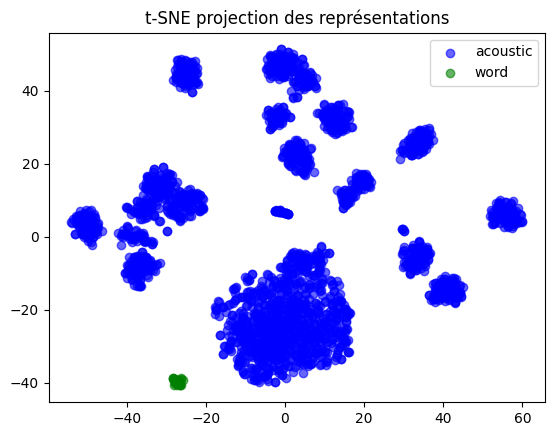

In [53]:
import matplotlib.pyplot as plt

colors = {'acoustic': 'blue', 'word': 'green'}
for label in ['acoustic', 'word']:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(all_repr_2d[idx, 0], all_repr_2d[idx, 1], c=colors[label], label=label, alpha=0.6)

plt.legend()
plt.title("t-SNE projection des représentations")
plt.show()


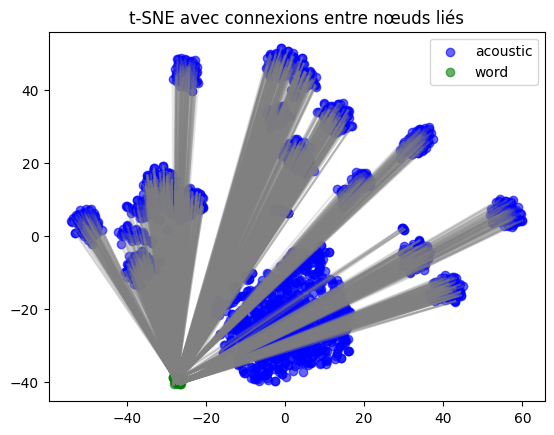

In [54]:
# Récupère les edges entre 'acoustic' et 'word'
dst, src = hetero_graph.edges(etype='related_to')  # ou l'inverse selon ton graphe

# Décale les indices dst car ils viennent après les acoustic dans all_repr_2d
offset = num_acoustic
for s, d in zip(src.tolist(), dst.tolist()):
    point1 = all_repr_2d[s]             # acoustic
    point2 = all_repr_2d[offset + d]    # word
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c='gray', alpha=0.2)

# Ré-affiche les points
for label in ['acoustic', 'word']:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(all_repr_2d[idx, 0], all_repr_2d[idx, 1], c=colors[label], label=label, alpha=0.6)

plt.legend()
plt.title("t-SNE avec connexions entre nœuds liés")
plt.show()
